### Feature engineering for Kaggle Iceberg Competition

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
%matplotlib inline

#### Read in the images and reshape them for plotting

In [60]:
df = pd.read_json("../data/train.json")

In [61]:
df.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [62]:
df['band_1rs'] = df['band_1'].map(lambda x: np.reshape(np.array(x), (75, 75)))
df['band_2rs'] = df['band_2'].map(lambda x: np.reshape(np.array(x), (75, 75)))

#### Get rid of the images that don't have an incident angle for EDA

In [70]:
df['inc_angle_is_str'] = df['inc_angle'].map(lambda x: type(x) == str)

In [75]:
df = df[df['inc_angle_is_str'] == False]

##### Split the iceberg and ships

In [315]:
icebergs_df = df.loc[df['is_iceberg'] == 1].sort_values(['inc_angle'])
ships_df = df.loc[df['is_iceberg'] == 0].sort_values(['inc_angle'])

##### First explore what icebergs and ships look like

In [105]:
def sample_and_plot(df, n=1):
    fig = plt.figure(figsize= (10,10))
    samples = df.sample(n)
    band_1 = samples['band_1rs']
    band_2 = samples['band_2rs']
    inc_angle = samples['inc_angle']
    
    for i, (b1, b2, inc_angle) in enumerate(zip(band_1, band_2, inc_angle)):
        ax = fig.add_subplot(n, 2, (2 * i) + 1)
        ax.imshow(b1)
        ax.set_title(f"Band: 1, Inc_Angle: {inc_angle}")
        ax = fig.add_subplot(n, 2, (2 * i) + 2)
        ax.imshow(b2)
        ax.set_title(f"Band: 2, Inc_Angle: {inc_angle}")

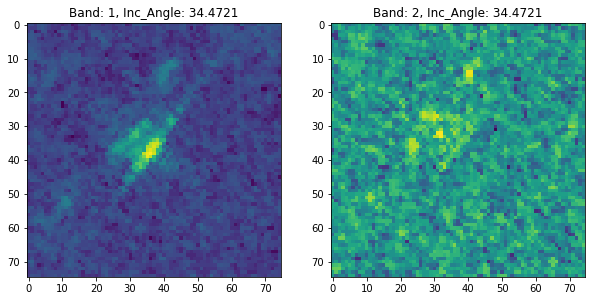

In [106]:
sample_and_plot(icebergs_df)

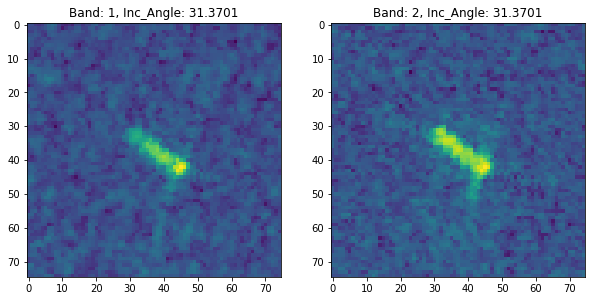

In [107]:
sample_and_plot(ships_df)

#### Standardize the images so that they are in 0-255

In [342]:
image = icebergs_df.sample(1)['band_2rs'].tolist()[0]

In [343]:
def rescale(image):
    upper = np.max(image)
    lower = np.min(image)
    return (image-lower)/(upper-lower)

In [344]:
image_rs = rescale(image)

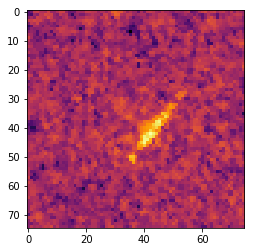

In [345]:
plt.imshow(image, cmap='inferno')

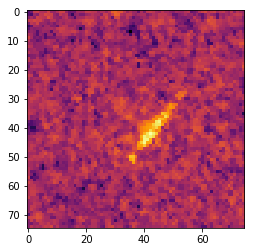

In [346]:
plt.imshow(image_rs, cmap='inferno')

##### First lets try to create some features Sobel Kernels (derivatives of the images in x and y)

##### Brief Explanation of how Sobel Kernels work:
https://www.evernote.com/l/AkMHxOAyExpHj7_PXkVpCq62-XyWk-NMHiU

##### Calculate the Sobel-fied images (is Sobel-fied a word? lolol)

In [347]:
def calc_sobel(image, ksize=3):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)
    return sobel_x, sobel_y

In [350]:
sobel_x, sobel_y = calc_sobel(image_rs)

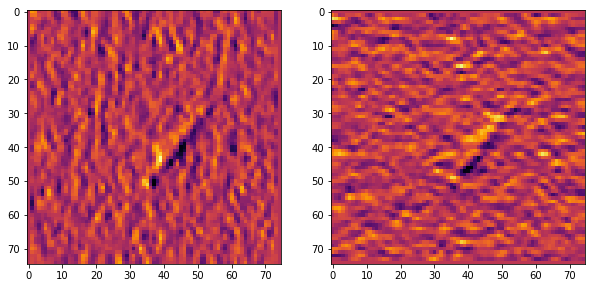

In [351]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(sobel_x, cmap='inferno')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(sobel_y, cmap='inferno')

##### Or we could do it by "hand" as we are using a kernel size of 3, it may be better to use the Scharr operator

In [352]:
from scipy import signal
def calc_sobel_by_hand(image, mode='SOBEL'):
    if mode == "SOBEL":
        xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    elif mode == "SCHARR":
        xder = np.array([[-3,0,3],[-10,0,10],[-3,0,3]])
        yder = np.array([[3,10,3],[0,0,0],[-3,-10,-3]])
    x_sobel = signal.convolve2d(image, xder, mode = 'same')
    y_sobel = signal.convolve2d(image, yder, mode = 'same')
    return sobel_x, sobel_y 

In [353]:
sobel_x, sobel_y = calc_sobel_by_hand(image_rs)

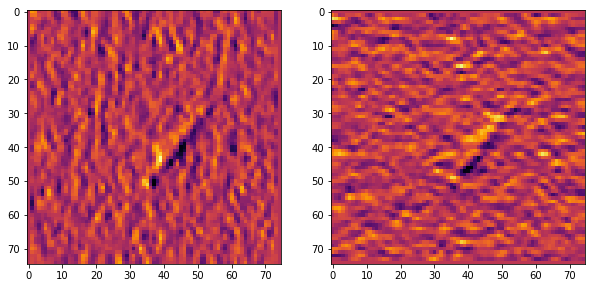

In [354]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(sobel_x, cmap='inferno')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(sobel_y, cmap='inferno')

##### Using the magnitudes to create new features

In [355]:
def calculate_magnitude_by_hand(image):
    x_sobel, y_sobel = calc_sobel(image)
    magnitude = np.hypot(x_sobel, y_sobel)
    return magnitude

In [369]:
image_mag = calculate_magnitude_by_hand(image_rs)

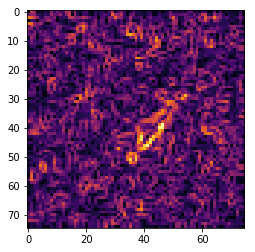

In [370]:
plt.imshow(image_mag, cmap='inferno')

##### Calculate the second derivative of the images 

In [371]:
def calculate_der2_by_hand(image):
    xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
    yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])
    image_xder2 = signal.convolve2d(image, xder2, mode = 'same')
    image_yder2 = signal.convolve2d(image, yder2, mode = 'same')
    return image_xder2, image_yder2

In [372]:
image_xder2, image_yder2 = calculate_der2_by_hand(iceberg)

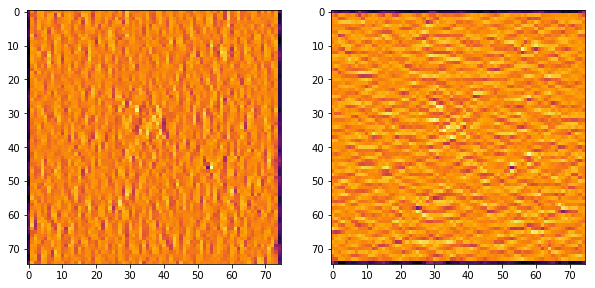

In [373]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image_xder2, cmap='inferno')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(image_yder2, cmap='inferno')

##### Using the Canny Edge Detector create some new features

##### Brief explanation of Canny Edge Detector here:
https://www.evernote.com/l/AkM2T4mzuD1Ij7WoFjNBPXhvTk_UeHQNajk

In [377]:
image_uint8 = (image_rs * 255).astype(np.uint8)

In [383]:
edges = cv2.Canny(iceberg.astype(np.uint8), 15, 50)

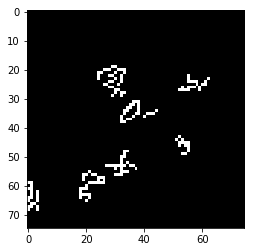

In [384]:
plt.imshow(edges, cmap='gray')

##### Using smoothing filters to create new features

In [394]:
# Normal blur
blur = cv2.blur(image_rs, (3, 3))

# Gaussian blur
g_blur = cv2.GaussianBlur(image_rs, (3, 3), 0)

# Median blur (this should be effective in reducting the salt and pepper noise)
m_blur = cv2.medianBlur(image_uint8, 3)

# Bilateral Filtering
bi_blur = cv2.bilateralFilter(image_uint8, 3, 25, 25)

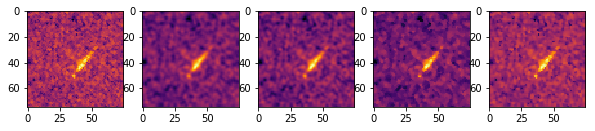

In [402]:
fig = plt.figure(figsize=(10, 10))
for i, img in enumerate([image_rs, blur, g_blur, m_blur, bi_blur], 1):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(img, cmap='inferno')

In [410]:
# Gabor Filtering
def build_filters():
    filters = []
    ksize = 11
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 
                                  sigma=4.0, 
                                  theta=theta, 
                                  lambd=10.0, 
                                  gamma=0.5, 
                                  psi=0, 
                                  ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

In [415]:
images = []
thetas = np.arange(0, np.pi, np.pi/16)
fils = build_filters()
for f in fils:
    images.append(signal.convolve2d(image_rs, f, mode='same'))

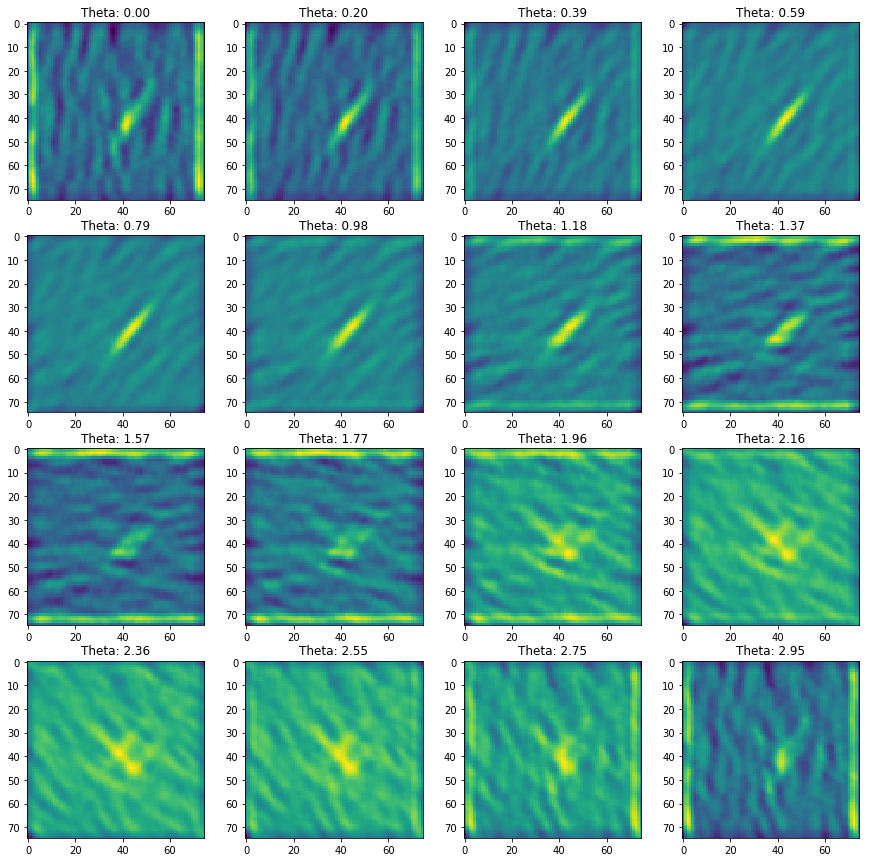

In [422]:
fig = plt.figure(figsize=(15, 15))
for i in range(len(thetas)):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(images[i])
    ax.set_title(f"Theta: {thetas[i]:.2f}")